# Lecture 8 - Matched Case-Control Scheme, Ordinal Regressors, and Final Wrap-Up

## Today's Learning Objectives

1. Describe how case-control sampling and matching can simultaneously be used to design a study.
2. Demonstrate the use of contrasts in ordinal regressors.
3. Relate how data are analyzed to how they are collected.

## Loading `R` Packages

In [1]:
options(repr.matrix.max.rows = 8, repr.matrix.max.cols = 10, warn = -1)
library(foreign)
library(tidyverse)
library(broom)
library(MASS)

── Attaching core tidyverse packages ────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select




## Previously...

We have explored in **observational studies** how to obtain **accurate and precise** statistical models to infer causality between an exposure factor $X$ and a given outcome of interest $Y$. Furthermore, in {doc}`lecture7_obs_sampling_schemes`, we introduce three different sampling schemes to assess them using a **proxy ground truth**.

Via different simulation studies, we ended up concluding that a case-control (CC) scheme (with a smaller sample size $n$) has a better performance when compared to cross-sectional (CS) and cohort (CO) schemes **when $Y = 1$ is rare in the population**.

However, note that all sampling schemes used a **Binary Logistic regression model** to infer causality between $Y$ and $X$.

Now, we might wonder: **can we improve our CC causal analysis even more by incorporating a more clever statistical tool?** Let us explore this.

## 1. Matched Case-Control Studies

Let us review the definition we provided for CC schemes:

> Case-control (CC) is a **retrospective scheme**. It will sample a group of subjects with the study's response success ($Y = 1$) and a group without ($Y = 0$). Half of the overall sample will correspond to subjects with $Y = 1$ and the other half to $Y = 0$. The researcher will ask each subject: *have you ever been exposed to the condition $X$ **in the past** ($X = 0$ never and $X = 1$ ever)*.

Those subjects with $Y = 1$ are the **cases** and those with $Y = 0$ are **controls**.

Furthermore, via the **proxy ground truth**, we concluded that a CC sampling scheme is the best among the three we checked in terms of **power** with a smaller sample size $n$ when $Y = 1$ is rare in the population. Our simulation studies included fitting a regression model involving $Y$, $X$, and $p$ confounders $C_j$ ($j = 1, \dots, p$).

### 1.1. An Alternative Data Collection

Regarding CC sampling schemes, **is it entirely acceptable to collect the data this way?** Yes, it is acceptable according to the following reasons:

- Let us think about the variables  $(Y, X , C_1, \dots, C_p)$ in the actual population of interest. Moreover, we presume the conditioned response $(Y | X, C_1, \dots, C_p)$ in our population of interest is governed by a regression equation.
- We create an artificial population by "cloning subjects."

- We build our artificial clone responses based on regression coefficients from an estimated model using a **previous representative sample** as training data. These responses include **induced random noise**. This is our  **proxy ground truth**.
- Then, we **directly** collect a CC sample with half of the subjects as controls and the other half as cases from the **proxy ground truth**.

Therefore, when sampling is costly (recall, we aim for sample sizes as small as possible!) and $Y = 1$ is rare, **a CC sampling is feasible and helpful**.

However, the statistical practice offers an alternative way to collect our CC data instead of **directly** collecting a CC sample with half of the subjects as controls and the other half as cases from our population of interest. It is called **CC-matching**.

Before we dig into this alternative CC data collection, let us build our **proxy ground truth** via the Western Collaborative Group Study (WCGS) data. Recall this study recruited **middle-aged men between the ages of 39 and 59 who were employees of ten Californian companies**. The data was collected on 3154 subjects between 1960 and 1961.

Moreover, the main statistical inquiry was:

> **Does a `Type A` behaviour pattern (`dibpat`) LEAD to a coronary heart disease (CHD) event (`chd69`)?**

From [Brand et al. (1976)](https://www.ahajournals.org/doi/pdf/10.1161/01.CIR.53.2.348), the levels of `dibpat` are defined as follows:

> *Methods for the assessment of the dichotomous behavior pattern by a structured psychological interview in the
WCGS have been described elsewhere. **Type A** behavior is characterized by enhanced aggressiveness and competitive drive, preoccupation with deadlines, and chronic impatience and sense of time urgency, in contrast with the more relaxed and less hurried **Type B** behavior pattern.*

We load the data and get rid of rows with missing data.

In [2]:
wcgs <- as_tibble(read.dta("../data/wcgs.dta"))
wcgs <- na.omit(wcgs) 
wcgs

age arcus behpat bmi      chd69 ⋯ typchd69 uni        weight wghtcat agec 
1    50  1     A1     31.32101 No    ⋯ 0        0.4860738  200    170-200 46-50
2    51  0     A1     25.32858 No    ⋯ 0        0.1859543  192    170-200 51-55
3    59  1     A1     28.69388 No    ⋯ 0        0.7277991  200    170-200 56-60
4    51  1     A1     22.14871 No    ⋯ 0        0.6244636  150    140-170 51-55
⋮    ⋮   ⋮     ⋮      ⋮        ⋮     ⋱ ⋮        ⋮          ⋮      ⋮       ⋮    
3098 41  0     B4     25.03378 No    ⋯ 0        0.27816987 195    170-200 41-45
3099 53  0     B4     25.79944 No    ⋯ 0        0.95139700 185    170-200 51-55
3100 54  0     B4     23.49076 No    ⋯ 0        0.57082593 150    140-170 51-55
3101 48  0     B4     30.26990 No    ⋯ 0        0.08677829 205    > 200   46-50

Then, we select our variables of interest:

- `dibpat`: Dichotomous behaviour pattern, a factor-type variable with two levels (`Type A` and `Type B`).
- `age`: Subject's age in years (a count-type variable).
- `bmi`: Subject's body mass index (BMI) in $\text{kg}/\text{m}^2$ (a continuous-type variable).
- `chol`: Subject's cholesterol levels in $\text{mg}/100 \text{ ml}$ (a continuous-type variable).
- `smoke`: Whether the subject smokes or not, a factor-type variable with two levels (`Yes` and `No`).
- `chd69`: Whether the subject experienced a coronary heart disease (CHD) event, a factor-type variable with two levels (`Yes` and `No`).

In [3]:
wcgs <- wcgs %>%
  dplyr::select(dibpat, age, bmi, chol, smoke, chd69)

Therefore $Y$ will be `chd69` and $X$ will be `dibpat`, whereas `age`, `bmi`, `chol` and `smoke` will be confounders.

Given the form of the model governing our **proxy ground truth**:

```
glm(chd69 ~ dibpat + age_bins + smoke + bmi_bins + chol_bins, family = "binomial", data = wcgs)
```

we need to create strata by confounder (**except for `smoke` which is already categorical**). These strata will be formed on a quartile basis.

In [4]:
wcgs <- wcgs %>%
  mutate(
    age_bins = cut(age, breaks = c(min(age), quantile(age, (1:3) / 4), max(age)), include.lowest = TRUE),
    bmi_bins = cut(bmi, breaks = c(min(bmi), quantile(bmi, (1:3) / 4), max(bmi)), include.lowest = TRUE),
    chol_bins = cut(chol, breaks = c(min(chol), quantile(chol, (1:3) / 4), max(chol)), include.lowest = TRUE)
  )

Then, we fit the governing model:

In [5]:
wcgs_bin_log_model <- glm(chd69 ~ dibpat + age_bins + smoke + bmi_bins + chol_bins,
  family = "binomial", data = wcgs
)

We record the corresponding estimated regression coefficients:

In [6]:
wcgs_coef_pop <- coef(wcgs_bin_log_model)

We proceed with creating the clones in our **proxy ground truth** `sim_pop` and shuffling its rows.

In [7]:
set.seed(554) # Reproducibility
sim_pop <- data.frame(
  dibpat = rep(wcgs$dibpat, each = 20),
  age_bins = rep(wcgs$age_bins, each = 20),
  smoke = rep(wcgs$smoke, each = 20),
  bmi_bins = rep(wcgs$bmi_bins, each = 20),
  chol_bins = rep(wcgs$chol_bins, each = 20)
)
# Shuffling rows
rows <- sample(nrow(sim_pop))
sim_pop <- sim_pop[rows, ]

Then, we build the response $Y$ (`chd69`).

In [8]:
pred_prob <- function(logit) {exp(logit) /(1 + exp(logit))} # pi hat formula

# Creating model matrix
model_matrix_sim_pop <- model.matrix(~ dibpat + age_bins + smoke + bmi_bins + chol_bins, data = sim_pop)

set.seed(554) # Reproducibility
sim_pop$chd69 <- rbinom(
  n = nrow(sim_pop), size = 1, prob = pred_prob(logit = model_matrix_sim_pop %*% wcgs_coef_pop)
)
sim_pop <- sim_pop %>% mutate(chd69 = as.factor(chd69))
sim_pop

dibpat age_bins smoke bmi_bins    chol_bins chd69
46844 Type B [39,42]  No    (24.4,25.8] (197,223] 0    
36954 Type B (50,59]  No    (25.8,38.9] [103,197] 0    
47173 Type B (42,45]  No    (23,24.4]   [103,197] 0    
44779 Type B (50,59]  No    (23,24.4]   (197,223] 0    
⋮     ⋮      ⋮        ⋮     ⋮           ⋮         ⋮    
13998 Type A (42,45]  No    (25.8,38.9] [103,197] 0    
43487 Type B [39,42]  No    [11.2,23]   [103,197] 0    
14393 Type A (42,45]  Yes   (25.8,38.9] [103,197] 0    
45693 Type B (50,59]  Yes   (25.8,38.9] [103,197] 0

We ended up with an artificial population of $N = 62,020$ subjects where $1,537 + 3,480 = 5,017$ subjects **experience (or will experience!)** a CHD event (`0` for `No` and `1` for `Yes`):

In [9]:
table(sim_pop$dibpat, sim_pop$chd69)

        
             0     1
  Type B 29203  1537
  Type A 27800  3480

Once we have our artificial population `sim_pop`, let us explain what **CC-matching** is. This particular form of CC sampling occurs when we are collecting our data. It has the following characteristics:

- Our **overall sample size** will be $n$.
- We sample $n / 2$ cases ($Y = 1$) from our population of interest. We already discussed the impact of oversampling cases and undersampling controls when the case $Y = 1$ is rare. Here we will keep a

$$\text{Case:Control ratio} = 1.$$

- When recording the binary variables $Y$ and $X$, we also record the confounders of interest $C_j$ **as strata**.

```{exercise}
:label: lecture8-q1

**Answer TRUE or FALSE:**

If we are part of the team designing the observational study, we must determine the set of confounding variables before running the study.

**A.** TRUE

**B.** FALSE
```

- Once we have the sampled $n / 2$ cases, we will start sampling our $n / 2$ controls ($Y = 0$).
- When sampling the $n / 2$ controls, each subject **will exactly match each confounding strata to their SINGLE case counterpart**. The variable $X$ will be allowed to vary.

```{admonition} What is the objective of this matched case-control sampling?
:class: hint

This alternative matching sampling also considers confounding variables, so we can allow our causal claims on the binary $X$ and $Y$ to be **STRONGER**. Note this particular scheme will be decided from the very beginning of the observational study.
```

**To illustrate this CC sampling scheme**, we will build the simulation function `sim_matched_CC`. The function will need the following arguments:

- `pop_data`: The population data from which we will draw the sample.
- `n`: The overall sample size $n$.

The function will return the **CC-matched sample**.

In [10]:
sim_matched_CC <- function(pop_data, n) {
  subsample_size <- n / 2
  sample_cases <- sample((1:nrow(pop_data))[pop_data$chd69 == 1],
    size = subsample_size, replace = F
  )
  # Keep the same n / 2 cases, but start fresh with picking controls!
  sample_controls <- rep(NA, length(sample_cases))
  # Start out with T/F indicator for the pool of all controls
  available_control <- pop_data$chd69 == 0
  # Going through cases one at a time
  for (i in 1:length(sample_cases)) {

    # What control is eligble to match to the ith case?
    # Any available control with matching confounder values!
    elegible_control <- available_control &
      (pop_data[, "age_bins"] == pop_data[sample_cases[i], "age_bins"]) &
      (pop_data[, "smoke"] == pop_data[sample_cases[i], "smoke"]) &
      (pop_data[, "bmi_bins"] == pop_data[sample_cases[i], "bmi_bins"]) &
      (pop_data[, "chol_bins"] == pop_data[sample_cases[i], "chol_bins"])

    # The index of the randomly selected control
    sample_controls[i] <- sample((1:nrow(pop_data))[elegible_control], size = 1)

    # And that control will be no longer available
    available_control[sample_controls[i]] <- FALSE
  }

  # Wrangling matched sample
  sample_by_pairs <- data.frame(
    dibpat_case = sim_pop$dibpat[sample_cases],
    dibpat_control = sim_pop$dibpat[sample_controls],
    sim_pop[sample_cases, c("age_bins", "smoke", "bmi_bins", "chol_bins")]
  )
  rownames(sample_by_pairs) <- 1:nrow(sample_by_pairs)

  return(sample_by_pairs)
}

We draw a **CC-matched sample** using the previous function from `sim_pop`. The overall sample size is $n = 500$.

In [11]:
set.seed(321) # Reproducibility
CC_matched_sample <- sim_matched_CC(pop_data = sim_pop, n = 500)
CC_matched_sample

dibpat_case dibpat_control age_bins smoke bmi_bins    chol_bins
1   Type B      Type A         (50,59]  Yes   [11.2,23]   (223,253]
2   Type B      Type A         (50,59]  No    (25.8,38.9] (223,253]
3   Type B      Type A         (50,59]  Yes   (23,24.4]   [103,197]
4   Type A      Type A         (42,45]  No    [11.2,23]   (223,253]
⋮   ⋮           ⋮              ⋮        ⋮     ⋮           ⋮        
247 Type A      Type B         (50,59]  Yes   (25.8,38.9] (253,645]
248 Type A      Type A         (50,59]  No    (25.8,38.9] (253,645]
249 Type A      Type A         (50,59]  Yes   [11.2,23]   (253,645]
250 Type B      Type A         [39,42]  Yes   (23,24.4]   (253,645]

This sample has 250 rows. In the context of the WCGS data, each row shows the matched confounding strata in their corresponding columns (`age_bins`, `smoke`, `bmi_bins`, and `chol_bins`). In addition, the columns `dibpat_case` and `dibpat_control` contain the $X$ values for the matched case and control.

### 1.2. A Different Data Analysis

In general, if we form a **CC-matched sample** using confounders $C_1, \ldots, C_p$; then, there is a bespoke procedure for estimating the logarithm of the odds ratio ($\text{log-OR}$) of $(Y , X| C_1, \ldots, C_p)$. 

```{warning}
**We do not have a free pass to fit a Binary Logistic regression model like a regular CC sample since we have matched pairs**. If we want to use the ordinary model from `glm()` with a **CC-matched sample**, **the sparse data problem** could arise (i.e., the number of strata is large relative to the amount of training data given that we also use the binned confounders to sample).

So instead, we will use what is called the McNemar test.
```

Each **matched pair** contributes to one of the four cells in the following contingency table in terms of $X$:

|  |  | **Control** |  |
| --- | --- | --- | --- |
|  |  | $X = 0$ | $X = 1$ |
| **Case** | $X = 0$ | $n_{0, 0}$ | $n_{0, 1}$ |
| | $X = 1$ | $n_{1, 0}$  | $n_{1, 1}$ |

These pairs $n_{0, 0}$ and $n_{1, 1}$ are called **concordant pairs**. On the other hand, the pairs $n_{0, 1}$ and $n_{1, 0}$ are called **discordant pairs**. The estimator of the OR is based on the **discordant pairs**

$$\text{OR} = \frac{n_{1, 0}}{n_{0, 1}}.$$

Recall the OR can be interpreted as follows:

- $\text{OR} = 1$ indicates the binary exposure $X$ **DOES NOT AFFECT** the odds of the binary outcome $Y$.
- $\text{OR} > 1$ indicates the binary exposure $X$ **IS ASSOCIATED WITH** (**OR CAUSES!**) **higher odds** of the binary outcome $Y$.
- $\text{OR} < 1$ indicates the binary exposure $X$ **IS ASSOCIATED WITH** (**OR CAUSES!**) **lower odds** of the binary outcome $Y$.

Under the McNemar test, the hypotheses are the same as in {doc}`lecture6_obs_stratifying_modelling`:

$$H_0\text{: log-OR} = 0$$
$$H_a\text{: log-OR} \neq 0.$$

Failing to reject $H_0$ gives statistical evidence that the binary exposure $X$ **DOES NOT AFFECT** the odds of the binary outcome $Y$ with a significance level $\alpha$.

The estimator of the $\text{log-OR}$ is

$$\hat{\text{log-OR}} = \log \bigg( \frac{n_{1, 0}}{n_{0, 1}} \bigg) = \log(n_{1, 0}) - \log(n_{0, 1}).$$

The $\text{log-OR}$ is **approximately Normal** with the following standard error (SE):

$$\text{SE} = \sqrt{\frac{1}{n_{1, 0}} + \frac{1}{n_{0, 1}}},$$

and the test statistic is

$$z_{\text{log-OR}} = \frac{\log(n_{1, 0}) - \log(n_{0, 1})}{\sqrt{\frac{1}{n_{1, 0}} + \frac{1}{n_{0, 1}}}}$$

In terms of our `CC_matched_sample`, we need to obtain the corresponding contingency table:

In [12]:
CC_matched_cont_table <- table(CC_matched_sample$dibpat_case, CC_matched_sample$dibpat_control)
CC_matched_cont_table

        
         Type B Type A
  Type B     43     39
  Type A     73     95

Then, we obtain the estimate of the $\text{log-OR}$ and its SE:

In [13]:
logOR_est <- log(CC_matched_cont_table[2 , 1]) - log(CC_matched_cont_table[1, 2])
round(logOR_est, 3)

[1] 0.627

In [14]:
logOR_se <- sqrt(1 / CC_matched_cont_table[2 , 1] + 1 / CC_matched_cont_table[1, 2])
round(logOR_se, 3)

[1] 0.198

We can obtain the OR by exponentiating this estimate. Note it is larger than 1, so the exposure to $X = 1$ causes **higher odds** of the binary outcome $Y$.

In [15]:
round(exp(logOR_est), 3)

[1] 1.872

Then, the test statistic is the following:

In [16]:
test_stat_logOR <- logOR_est / logOR_se
round(test_stat_logOR, 3)

[1] 3.161

With $\alpha = 0.05$, we reject $H_0$ since
    
$$z_{\text{log-OR}} = 3.161 > 1.96 = z_{1 - \alpha /2}$$

Therefore, we have statistical evidence to state that the population $\text{log-OR} \neq 0$. Analogously, we can build a 95% confidence interval (CI) as follows:

$$\hat{\text{log-OR}} \pm 1.96 \times \text{SE}$$

In [17]:
CI_logOR <- round(c(logOR_est - qnorm(1 - 0.05 / 2) * logOR_se, logOR_est + qnorm(1 - 0.05 / 2) * logOR_se), 3)
CI_logOR

[1] 0.238 1.016

Let us compare the results of the **CC-matched sample** versus another **CC-unmatched sample**. To obtain an estimate of the $\text{log-OR}$, we will fit a Binary Logistic regression model.

In [18]:
set.seed(554) # Reproducibility
CC_sampled_subjects <- c( sample((1:nrow(sim_pop))[sim_pop$chd69 == "0"], size = 500 / 2, replace = F), # Sampling subjects without replacement
  sample((1:nrow(sim_pop))[sim_pop$chd69 == "1"], size = 500 / 2, replace = F)
) 
CC_sample <- sim_pop[CC_sampled_subjects, ] # Collecting data from artificial population

#Fitting Binary Logistic regression with non-matched CC sample
CC_bin_log_model <- glm(chd69 ~ dibpat + age_bins + smoke + bmi_bins + chol_bins,
                       family = "binomial", data = CC_sample
)
summary_CC <- tidy(CC_bin_log_model, conf.int = TRUE) %>% mutate_if(is.numeric, round, 3)
summary_CC[2, ]

term         estimate std.error statistic p.value conf.low conf.high
1 dibpatType A 0.754    0.209     3.6       0       0.345    1.167

**How do both case-control sampling schemes compare?**

Since the **proxy ground truth** in `sim_pop` has an underlying effect of `dibpat` as follows:

In [20]:
round(wcgs_coef_pop["dibpatType A"], 2)

dibpatType A 
        0.72

Then, both CC sampling schemes seem to be equally accurate and precise. Nevertheless, **they are just single replicates**. Hence, **we need to run their corresponding simulation studies**.

### 1.3. Running Simulation Studies Using the Two Case-Control Sampling Schemes

The function `sim_study()` draws the corresponding samples by CC scheme. Then, it runs their corresponding statistical analysis. It needs the following arguments:

- `pop_data`: The population data from which we will draw the sample.
- `n`: The overall sample size by scheme.
- `alpha`: Significance level $\alpha$.
- `log_OR`: The "true" log-OR each scheme is willing to estimate.
- `num_replicates`: The number of replicates by scheme.

In [21]:
sim_study <- function(pop_data, n, alpha, log_OR, num_replicates) {
  res <- list(NULL) # Setting up matrix with metrics
  res[[1]] <- res[[2]] <- matrix(NA, num_replicates, 3)

  suppressMessages(
    for (lp in 1:num_replicates) { # Otherwise, we get "Waiting for profiling to be done..."
      # Obtaining samples
      # CC
      CC_sampled_subjects <- c(
        sample((1:nrow(pop_data))[pop_data$chd69 == "0"],
          size = n / 2, replace = F
        ),
        sample((1:nrow(pop_data))[pop_data$chd69 == "1"],
          size = n / 2, replace = F
        )
      )
      CC_sample <- pop_data[CC_sampled_subjects, ]

      # CC-matched
      CC_matched_sample <- sim_matched_CC(pop_data = sim_pop, n = n)
      CC_matched_cont_table <- table(
        CC_matched_sample$dibpat_case,
        CC_matched_sample$dibpat_control
      )

      # Do the three analyses
      # CC
      CC_bin_log_model <- glm(chd69 ~ dibpat + age_bins + smoke + bmi_bins + chol_bins,
        family = "binomial", data = CC_sample
      )
      # CC-matched
      logOR_est <- log(CC_matched_cont_table[2, 1]) - log(CC_matched_cont_table[1, 2])
      logOR_se <- sqrt(1 / CC_matched_cont_table[2, 1] + 1 / CC_matched_cont_table[1, 2])

      # and the takeaways
      res[[1]][lp, ] <- c(coef(CC_bin_log_model)["dibpatType A"], confint(CC_bin_log_model)["dibpatType A", ])
      res[[2]][lp, ] <- c(
        logOR_est, logOR_est - qnorm(1 - alpha / 2) * logOR_se,
        logOR_est + qnorm(1 - alpha / 2) * logOR_se
      )
    }
  )

  # Summaries
  BIAS <- sapply(
    res,
    function(mat) {
      mean(mat[, 1]) - log_OR
    }
  )
  vrnc <- sapply(res, function(mat) {
    var(mat[, 1])
  })
  CVRG <- sapply(res,
    function(mat, trg) {
      mean((mat[, 2] < trg) & (trg < mat[, 3]))
    },
    trg = log_OR
  )
  PWR <- sapply(res, function(mat) {
    mean(mat[, 2] > 0)
  })
  RMSE <- sqrt(BIAS^2 + vrnc)

  opt <- cbind(BIAS, RMSE, CVRG, PWR)
  rownames(opt) <- c("Case-Control (CC)", "Case-Control Matched (CC-Matched)")

  return(opt)
}


The function returns the following metrics:

- **BIAS:** The average, over the `num_replicates`, of $\hat{\text{log-OR}} - \text{log-OR}$. The larger the average, the less accuracy.
- **ROOT-MEAN-SQUARED ERROR (RMSE):** The square root of the average (over the `num_replicates`) of $(\hat{\text{log-OR}} - \text{log-OR})^{2}$.  It has the following characteristics:
    - Interpretable as the typical magnitude of estimation error.
    - Captures bias and variance involved in the procedure.
- **COVERAGE (CVRG):** The proportion (among the `num_replicates`) of the 95% CIs that contain the "true" $\log\text{-OR}$.
- **POWER (PWR):** It is applicable when $\text{log-OR} \neq 0$. The proportion of the `num_replicates` CIs that exclude zero.

We run the simulation studies with an **overall** $n = 100, 250, 500$.

In [22]:
set.seed(554) # Reproducibility
sim_study_n_100 <- sim_study(
  pop_data = sim_pop, n = 100, alpha = 0.05,
  log_OR = wcgs_coef_pop["dibpatType A"], num_replicates = 500
)

In [23]:
set.seed(554) # Reproducibility
sim_study_n_250 <- sim_study(
  pop_data = sim_pop, n = 250, alpha = 0.05,
  log_OR = wcgs_coef_pop["dibpatType A"], num_replicates = 500
)

In [24]:
set.seed(554) # Reproducibility
sim_study_n_500 <- sim_study(
  pop_data = sim_pop, n = 500, alpha = 0.05,
  log_OR = wcgs_coef_pop["dibpatType A"], num_replicates = 500
)

Finally, we obtain the corresponding performance metrics.

In [25]:
round(sim_study_n_100, 4)

BIAS   RMSE   CVRG PWR  
Case-Control (CC)                 0.1621 0.5850 0.93 0.446
Case-Control Matched (CC-Matched) 0.0283 0.4507 0.97 0.388

In [26]:
round(sim_study_n_250, 4)

BIAS   RMSE   CVRG  PWR  
Case-Control (CC)                 0.0384 0.3226 0.926 0.710
Case-Control Matched (CC-Matched) 0.0369 0.2787 0.958 0.794

In [27]:
round(sim_study_n_500, 4)

BIAS   RMSE   CVRG  PWR  
Case-Control (CC)                 0.0377 0.2111 0.946 0.972
Case-Control Matched (CC-Matched) 0.0245 0.1893 0.968 0.972

```{admonition}  What is the conclusion by looking at these metrics by CC sampling scheme?
:class: hint
The **CC-matched** scheme shows a smaller average bias with $n = 100$; thus, it is more accurate than the **CC-non matched** scheme using this sample size. The same situation applies to the RMSE. Nonetheless, the trade-off is a smaller power for **CC-matched**. The power is practically equal once we increase the sample size, but the **CC-matched** shows a smaller average bias and RMSE.
```

## 2. Ordinal Regressors

You might have noticed that throughout the regression courses, until this block, we did not **explicitly** work with **ordinal regressors** (i.e., categorical factors with ordered categories). Furthermore, you might have noticed that the numerical confounding strata (such as those in the WCGS observational models) are actually ordinal regressors!

Coding these ordinal regressors in the usual **dummy variable way** (`0`s and `1`s along with a baseline factor level) is not a substantial statistical inconsistency **compared to using Multinomial regression for an ordinal response**. However, you can gain additional insight by coding these ordinal regressors using **contrasts**.

In Statistics, a **contrast** is **a vector whose elements add up to zero**. This **contrast** will allow us to compare the levels of a given factor. Before we get into concrete **contrast** methods, let us check the data we will use in this section.

### 2.1. The Online Store Dataset

Suppose your work for a company that runs a high-end website store. You know your customers are susceptible to discounts, i.e., they tend to buy **more and more** as you increase the discount percentages. Hence, you decide to run an **A/B/n testing** using a **randomized balanced design** of 20 customers per treatment. Your sample has $n = 80$ subjects. The `ABn_purchase_data` has the following variables:

- `discount`: Your treatment variable with **four increasing EQUALLY SPACED discounts** (`2.5`, `5`, `7.5`, and `10`% off).
- `purchase`: Your continuous response of interest in CAD, the amount of money each subject spent given their respective **overall discount percentage**.

In [28]:
ABn_purchase_data <- read_csv("../data/ABn_purchase_data.csv", show_col_types = FALSE)
ABn_purchase_data

discount purchase
1  2.5      520.4311
2  2.5      436.4336
3  2.5      477.9415
4  2.5      394.7154
⋮  ⋮        ⋮       
77 10       4605.868
78 10       4305.460
79 10       4099.567
80 10       4281.010

Note that `discount` should be taken as an ordinal factor in this **A/B/n testing**. Let us convert it.

In [29]:
ABn_purchase_data$discount <- ordered(ABn_purchase_data$discount)
str(ABn_purchase_data)

spc_tbl_ [80 × 2] (S3: spec_tbl_df/tbl_df/tbl/data.frame)
 $ discount: Ord.factor w/ 4 levels "2.5"<"5"<"7.5"<..: 1 1 1 1 1 1 1 1 1 1 ...
 $ purchase: num [1:80] 520 436 478 395 458 ...
 - attr(*, "spec")=
  .. cols(
  ..   discount = col_double(),
  ..   purchase = col_double()
  .. )
 - attr(*, "problems")=<externalptr> 


### 2.2. Main Statistical Inquiry

Our main statistical inquiry is: 

> **By how much the mean customer spending increases from one discount percentage to another?**

This inquiry appeals to the ordered factor `discount`. Therefore, we will use ordinary least-squares (OLS) and contrasts to answer it. 

### 2.3. Exploratory Data Analysis

We proceed with an exploratory data analysis (EDA). The plot shows the 20 randomized customers as points with treatments on the $x$-axis and their purchases on the $y$-axis. Note that customer spending graphically increases along with the discount percentage.

In [30]:
options(repr.plot.height = 8, repr.plot.width = 14)

ABn_plot <- ggplot(ABn_purchase_data) +
  aes(x = discount, y = purchase) +
  geom_point(shape = 1, size = 6, color = "gold3") +
  theme(
    plot.title = element_text(size = 24, face = "bold"),
    axis.text = element_text(size = 17),
    axis.title = element_text(size = 21),
    legend.position = "right",
    legend.title = element_text(size = 21, face = "bold", margin = margin(r = 1, unit = "cm")),
    legend.text = element_text(size = 17, margin = margin(r = 3, unit = "cm")),
    legend.key.size = unit(3, "cm")
  ) +
  xlab("Discount (% Off)") +
  ylab("Customer Spending (CAD)") +
  ggtitle("Customer Spending by Discount Scheme")

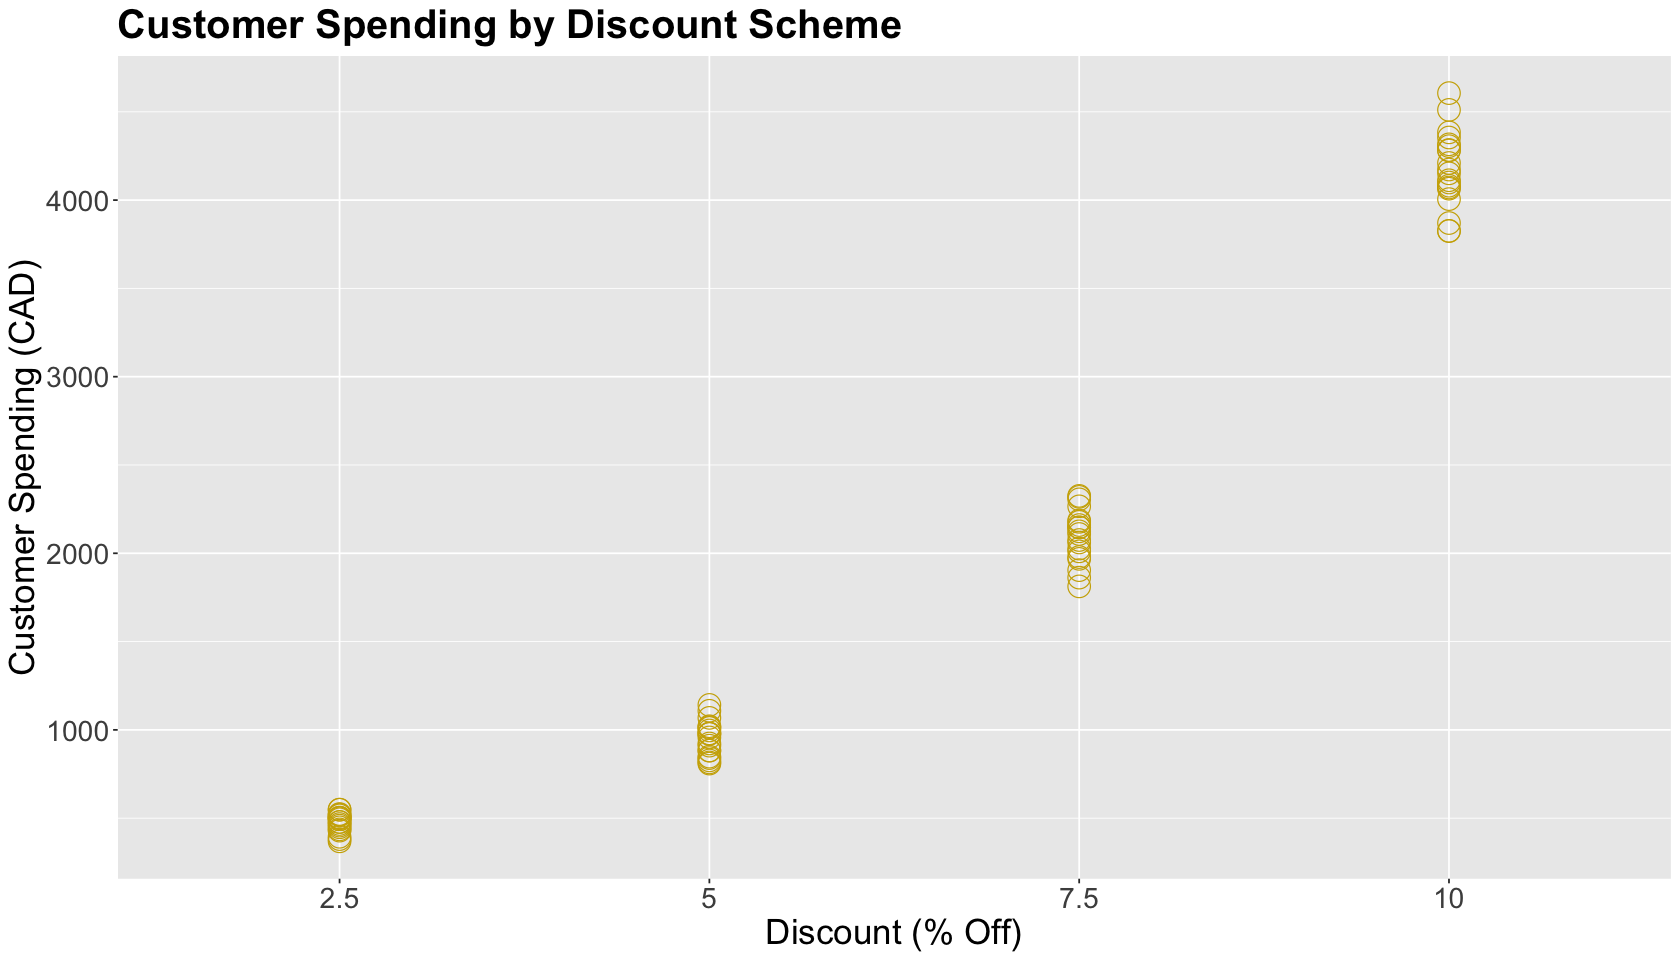

In [31]:
ABn_plot

### 2.4. Regression Model and Polynomial Contrasts

We will fit a **balanced one-way analysis of variance (ANOVA)** via `lm()`, i.e., OLS with an ordered factor. But before fitting this model, we need to proceed with contrasts. 

By default, `R` uses **polynomial contrasts** in ordered-type factors. Roughly speaking, if we use **polynomial contrasts** in an ordered factor of $k$ levels, we would fit $k − 1$ polynomials. We will be decomposing the data into these polynomial trends. **Therefore, the primary inferential purpose of these polynomial contrasts is to TEST polynomial trends in the ordered data**.

In this case, we have $k = 4$ levels in `discount`. Hence, we will have **linear (`L`)**, **quadratic (`Q`)**, and **cubic (`C`) contrasts**. These contrasts are shown below as vectors by column.

In [32]:
round(contr.poly(4), 2)

.L    .Q   .C   
[1,] -0.67  0.5 -0.22
[2,] -0.22 -0.5  0.67
[3,]  0.22 -0.5 -0.67
[4,]  0.67  0.5  0.22

These contrasts have the following characteristics:

- As previously stated, **the elements by vector add up to zero**.
- The three vectors are orthogonal, i.e., **the pairwise dot products are equal to zero**. **This characteristic will statistically allow decomposing the polynomial trends in the ordered data.**

Now, we can fit our regression model.

In [33]:
OLS_poly_cont_ABn <- lm(purchase ~ discount, data = ABn_purchase_data)
tidy(OLS_poly_cont_ABn) %>% mutate_if(is.numeric, round, 3)

term        estimate std.error statistic p.value
1 (Intercept) 1924.805 15.653    122.964   0.000  
2 discount.L  2740.092 31.307     87.524   0.000  
3 discount.Q   801.705 31.307     25.608   0.000  
4 discount.C    57.179 31.307      1.826   0.072

The `tidy()` output shows the corresponding estimate for the `(Intercept)` and the polynomial contrasts. The hypotheses to test these polynomial contrasts are different from the regular hypotheses to test regression terms.

$$H_0\text{: there is no GIVEN trend in the ordered data}$$
$$H_a\text{: there is a GIVEN trend in the ordered data.}$$

The word **GIVEN** will be replaced accordingly: **LINEAR** (`discount.L`), **QUADRATIC** (`discount.Q`), and **CUBIC** (`discount.C`). With $\alpha = 0.05$, we can conclude that our ordered `discount` data has **LINEAR** and **QUADRATIC** trends.

> **Heads-up:** Note the equal SEs by contrast. This is a modelling assumption in a balanced ANOVA **FOR ALL TYPES OF CONTRASTS IN GENERAL** (i.e., equal variability among the contrasts).

Using **polynomial contrasts** in a regression model is analogous to fitting polynomial regression models. We can see below the graphical representation of our estimations using this example. Note how the **quadratic** and **cubic** in-sample predictions are practically overlapped.

In [34]:
ABn_plot <- ABn_plot +
  geom_smooth(aes(x = unclass(discount), color = "1"),
    formula = y ~ x,
    method = lm, se = FALSE, size = 0.8
  ) +
  geom_smooth(aes(x = unclass(discount), color = "2"),
    formula = y ~ poly(x, 2),
    method = lm, se = FALSE, size = 0.8
  ) +
  geom_smooth(aes(x = unclass(discount), color = "3"),
    formula = y ~ poly(x, 3),
    method = lm, se = FALSE, size = 0.8
  ) +
  scale_color_discrete("Trend", labels = c("Linear", "Quadratic", "Cubic")) +
  ggtitle("Purchases versus Discounts by Polynomial Contrasts") +
  scale_x_discrete(labels = c("2.5% Off", "5% Off", "5% Off", "10% Off")) + 
  scale_color_brewer(palette = "Dark2") +
  scale_color_discrete("Trend", labels = c("Linear", "Quadratic", "Cubic"))

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


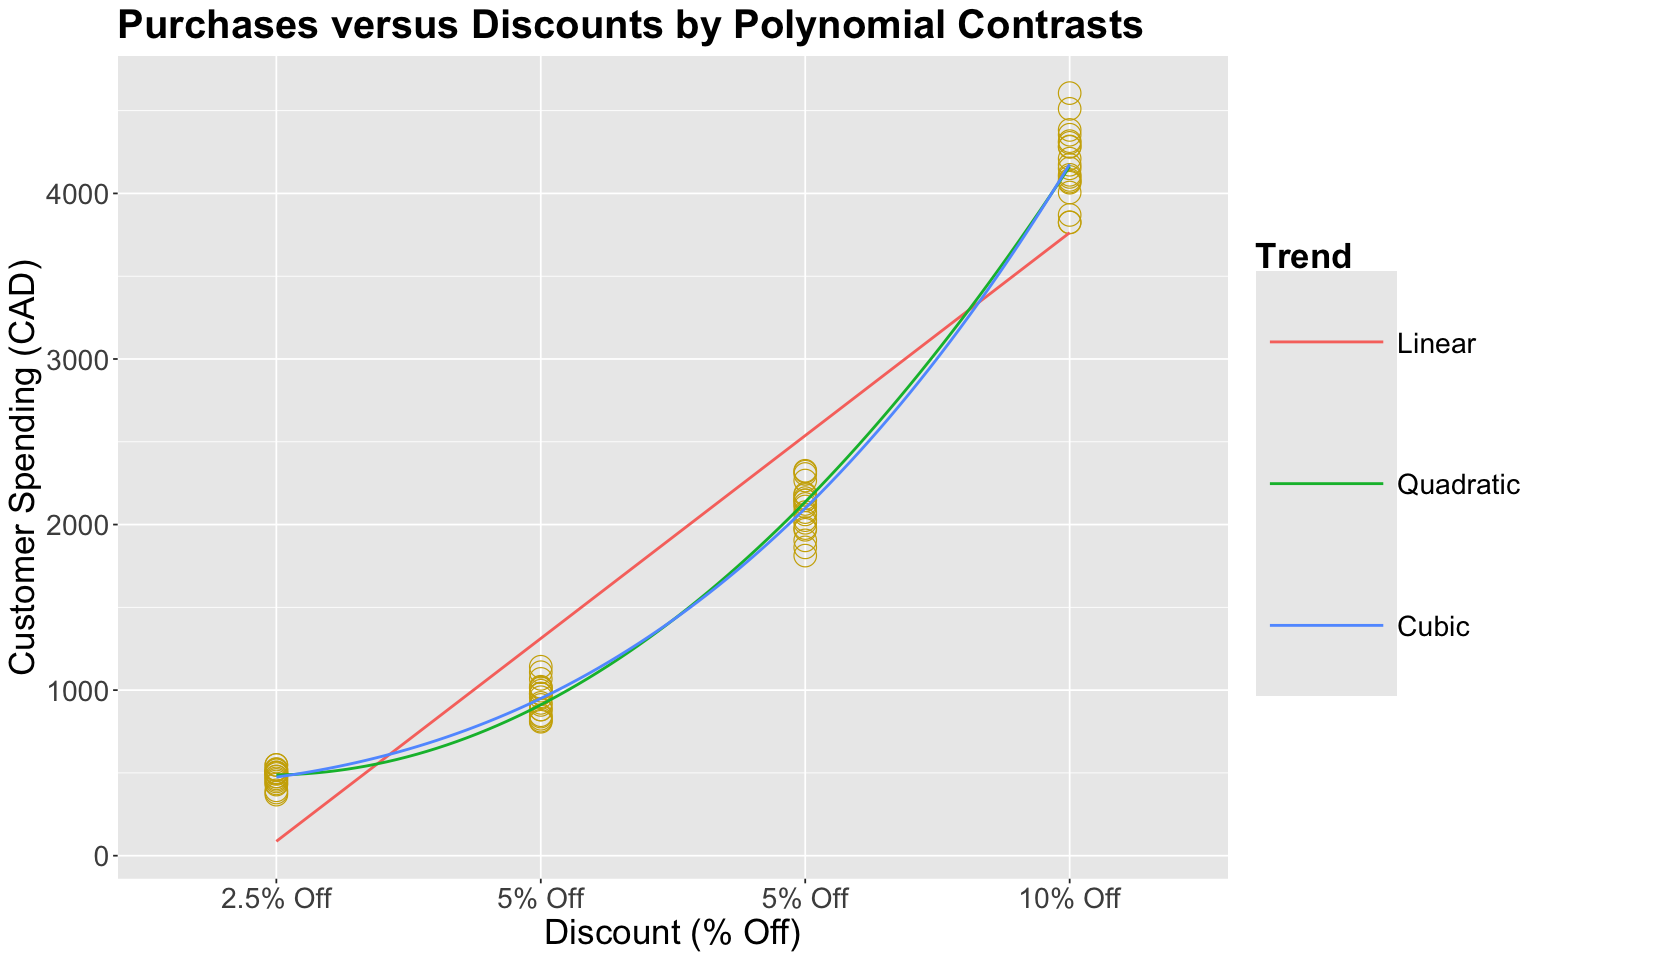

In [35]:
ABn_plot

For inferential purposes, these **polynomial contrasts** are suitable to test trends in our ordered data. Moreover, **they have the potential to be helpful in predictive inquiries**. However, they are hard to interpret in terms of our **main statistical inquiry**. The corresponding **design matrix** used in `OLS_poly_cont_ABn` is shown below. This matrix results from multiplicating a raw dummy variable **design matrix** times the previously shown three orthogonal vectors.

In [36]:
OLS_poly_cont_ABn %>% model.matrix()

(Intercept) discount.L discount.Q discount.C
1  1           -0.6708204 0.5        -0.2236068
2  1           -0.6708204 0.5        -0.2236068
3  1           -0.6708204 0.5        -0.2236068
4  1           -0.6708204 0.5        -0.2236068
⋮  ⋮           ⋮          ⋮          ⋮         
77 1           0.6708204  0.5        0.2236068 
78 1           0.6708204  0.5        0.2236068 
79 1           0.6708204  0.5        0.2236068 
80 1           0.6708204  0.5        0.2236068

Alternatively to polynomial contrasts, let us explore **successive differences contrasts**.

### 2.5. Regression Model and Succesive Differences Contrasts

There is an alternative contrast modelling to address our main statistical inquiry and make inferential interpretations more straightforward. They are the **successive differences contrasts**. If we want to answer whether differences exist between the ordered levels, we will check these **successive differences contrasts**. 

The model estimates in these contrasts are the differences between the means of the second and first levels, the third and second levels, etc. We have to set up the `R` contrasts setting as follows:

In [37]:
options(contrasts = c("contr.treatment", "contr.sdif"))

Then, we fit the OLS model.

In [38]:
OLS_succesive_ABn <- lm(purchase ~ discount, data = ABn_purchase_data)
tidy(OLS_succesive_ABn, conf.int = TRUE) %>% mutate_if(is.numeric, round, 2)

term           estimate std.error statistic p.value conf.low conf.high
1 (Intercept)    1924.80  15.65     122.96    0       1893.63  1955.98  
2 discount5-2.5   474.84  44.27      10.72    0        386.66   563.02  
3 discount7.5-5  1148.69  44.27      25.94    0       1060.51  1236.87  
4 discount10-7.5 2078.25  44.27      46.94    0       1990.07  2166.43

In the `tidy()` output, we intepret the $p$-values of these contrasts as in a regular regression term. All these terms are statistically significant with $\alpha = 0.05$. We can also obtain the corresponding 95% CIs. Our statistical inquiry can be answered as follows:

- The mean customer spending increases by \$474.84 when the discount increases from 2.5 to 5%.
- The mean customer spending increases by \$1148.69 when the discount increases from 5 to 7.5%.
- The mean customer spending increases by \$2078.25 when the discount increases from 7.5 to 10%.

## 3. Final Wrap-Up

This course covered two fundamental classes of studies: **experimental** and **observational**. Additionally, we explored different ways to perform **Power Analysis** (i.e., adequate sample size computations).

### 3.1. Experimental Versus Observational Studies

In **experimental studies** (e.g., A/B or A/B/n testings), we fully control our **treatments** of interest. We can **randomize** our **experimental units** to either one of these treatments before running our experiment. Treatment **randomization** will get rid of any potential confounders that might damage the **accuracy** of our **effect** estimations (when compared to analyses where we do not take them into account).

Thus, experimental **randomization** is a powerful tool that will allow you to infer causality between your $Y$ and a given set of $X$s. Recall that **treatment randomization** can be done via two fundamental **designs**:

- **Straightforward randomization.** We directly randomize our **experimental units** to either one of the **treatments** of interest. This design does not take into account any additional factors when randomizing.

- **Blocking.** We group our **experimental units** by common characteristics (i.e., **homogeneous blocks**) before randomizing. This will ensure we obtain accurate and precise **estimated treatment effects**. The golden rule in this design strategy is the following: **"block what you can, randomize what you cannot."**

In **observational studies**, treatment randomization is infeasible. Therefore, we must use other statistical strategies to infer causality between a given $X$ and an outcome $Y$. Analogous to blocking in experimental designs, we use **stratification** via our identified **confounders**. 

Note we need to **temper our causal statements** in this class of studies since we need to fulfil many different modelling assumptions (some more challenging than others). Moreover, assessing these assumptions implies careful model selection and multiple testing corrections.

There is more than one **sampling scheme** to execute an **observational study**. Using a **proxy ground truth** in different simulation studies, we checked the accuracy and precision of these schemes:

- **Cross-sectional (CS, a contemporaneuous scheme).**
- **Case-control (CC, a restrospective scheme).** This scheme can be **unmatched** or **matched**.
- **Cohort (CO, a prospective scheme).**

More specifically, in **matched CC**, we explored the importance of adapting our statistical analysis to how we collect our data. 

### 3.2. Causal Interpretations: It is all about making "proper" comparisons

**This applies to both experimental and observational studies.** It should be proper to compare an $X = 0$ group of people to an $X = 1$ group of people in terms of $Y$. As previously stated, there has to be **homogeneity** - everyone in both groups is very similar to each other (confounders $C_j$). 

### 3.3. Strength of Story

**Randomization** in **experimental studies** can lead to an airtight case that $X$ has a causal influence on $Y$. On the other hand with **observational studies**, **we can try our best to identify/collect/use confounding variables**. There is always a potential caveat!

### 3.4. Statistical Thinking in Design of Studies

Recall that study design is critical. Hence, we need to make the following decisions depending on the class of study:

1. **Experimental studies** 
    - Deciding on **blocking** versus **non-blocking** our **experimental units** is critical. To take advantage of **blocking**, our blocks need to be well-defined (low within-block variation and high between-block variation). Otherwise, we might estimate biased effects along with a small power.
    - We need to take **Power Analysis** into account. This is an a priori choice of how much data we need, so we can be convinced that $X$ has a causal effect on $Y$ (if, in fact, the magnitude of this effect is **weak** or **stronger**).
    - **Early stopping** is another point to consider. We can consider it, but we need to be cautious and use **principled peeking** to avoid inflating type I error and decreasing power.
2. **Observational studies** 

    - Note there is more than one way to collect a sample from a population. Furthermore, the sampling schemes are in function on different temporalities.
    - A CS scheme is basically a **simple random sample**.
    - A CC scheme can be **matched** or **non-matched**. Recall that oversampling cases is beneficial for the precision of our estimates.
    - A CO scheme implies a careful follow-up.

In data analysis, methods of analysis must reflect the structure of data collection:

- If our study is making **multiple comparisons** and we are concerned about **family-wise error rate**, then our analysis needs to reflect this.
- In **randomized A/B testing**, if we are going to intermittently **peek** at the incoming data and perhaps stop the experiment **early**, then our analysis needs to reflect this.
- In the **matched case-control analysis**, the appropriate analysis looks **nothing** like the appropriate analysis of **unmatched case-control data**.

### 3.5. A Final Statistical Reflection

We need to think **holistically** when dealing with **statistical studies in Data Science**. The following data pipeline is clearly in play:

- How data are collected.
- How data are analyzed.
- How conclusions are drawn.
- The strength of the resulting story (i.e., how robust the data story-telling is).

This process relies on **solid expertise from a diverse team (not just Data Scientists)**. You will provide your statistical expertise via tools from the following courses:

- **DSCI 551:** Fundamentals of probability.
- **DSCI 552:** Fundamentals of frequentist statistical inference.
- **DSCI 561:** Fundamentals of OLS regression.
- **DSCI 562:** Advanced frequentist regression techniques.
- **DSCI 554:** How we applied the previous learning within a frequentist causal inference framework.

If we want to switch to Bayesian statistics, **DSCI 553** is the way to go.